In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from scipy.stats import entropy
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_MAIN = pd.read_csv('/home/crazyjeannot/Documents/doctorat/data/data_chapitres/TRAINING_data/MAIN_DF.csv')
df_MAIN.set_index("Unnamed: 0", inplace = True)
df_MAIN = df_MAIN.replace(np.nan, 0)

In [22]:
def normalize_vectors_as_probabilities(df):
    # Get the columns containing the vectors (excluding the 'date' column)
    vector_columns = [col for col in df.columns if col != 'date']

    # Create the MinMaxScaler object
    scaler = MinMaxScaler()

    # Normalize each vector to represent a probability distribution
    for col in vector_columns:
        vector = df[col].values.reshape(-1, 1)
        normalized_vector = scaler.fit_transform(vector).flatten()
        df[col] = normalized_vector

    return df

In [23]:
df_MAIN_normalized = normalize_vectors_as_probabilities(df_MAIN)

In [5]:
def normalize_vectors_as_probabilities(df):
    # Get the columns containing the vectors (excluding the 'date' column)
    vector_columns = [col for col in df.columns if col != 'date']

    # Normalize each vector to represent a probability distribution
    for col in vector_columns:
        vector = df[col].values
        abs_vector = np.abs(vector)
        vector_sum = np.sum(abs_vector)
        if vector_sum > 0:
            normalized_vector = abs_vector / vector_sum  # Normalize to sum up to 1
            df[col] = normalized_vector

    return df

In [6]:
df_MAIN_normalized = normalize_vectors_as_probabilities(df_MAIN)

In [36]:
## Two normalizations, first one gets better results ?

In [24]:
def get_df_with_dates(df):
    df_res = df.copy()
    list_date = []
    for elem in df_res.index:
        list_date.append(int(elem.split('_')[0]))
    df_res['date'] = list_date

    return df_res

In [25]:
df_MAIN_dated = get_df_with_dates(df_MAIN_normalized)

In [26]:
def calculate_entropy(df, window, first_date, last_date):
    NOVELTY, INFLUENCE, novels, dates = [], [], [], []
    for index, row in tqdm(df.iterrows(), total=len(df)):
        current_date = row['date']
        if current_date-window < first_date or current_date+window > last_date:
            continue
        start_date = max(first_date, current_date - window)
        end_date = min(last_date, current_date + window)

        # Filter texts within the specified window
        novelty_texts = df[(df['date'] >= first_date) & (df['date'] <= start_date)].drop('date', axis=1)
        influence_texts = df[(df['date'] >= end_date) & (df['date'] <= last_date)].drop('date', axis=1)

        # Compute the entropy of the text
        text_novelty = entropy(row.drop('date').values, np.mean(novelty_texts.values, axis=0))
        text_influence = entropy(row.drop('date').values, np.mean(influence_texts.values, axis=0))

        NOVELTY.append(text_novelty)
        INFLUENCE.append(text_influence)
        novels.append(index)
        dates.append(current_date)
    return NOVELTY, INFLUENCE, novels, dates


In [27]:
NOVELTY, INFLUENCE, novels, dates = calculate_entropy(df_MAIN_dated, 35, 1811, 2020)

  0%|          | 0/2940 [00:00<?, ?it/s]

In [28]:
def net_entropy(indexes, dates, entropies):
    net_index, net_dates, net_entropy = [], [], []
    i=0
    for index, date, entropy in zip(indexes, dates, entropies):
        if ~np.isinf(entropy):
            net_index.append(str(index))
            net_dates.append(int(date))
            net_entropy.append(float(entropy))
        else:
            i+=1
    print("faulty entropy values : ", i)
    return net_index, net_dates, net_entropy

In [29]:
net_novels_nov, net_dates_nov, net_NOVELTY = net_entropy(novels, dates, NOVELTY)

faulty entropy values :  323


In [30]:
net_novels_inf, net_dates_inf, net_INFLUENCE = net_entropy(novels, dates, INFLUENCE)

faulty entropy values :  46


In [31]:
def get_df_to_plot(dates, entropy_values):
    # Calculate the mean entropy for each date and handle infinite values
    unique_dates = np.unique(dates)
    mean_entropy = []

    for date in unique_dates:
        indices_for_date = np.where(dates == date)[0]
        entropy_for_date = np.array(entropy_values)[indices_for_date]
        
        if len(entropy_for_date) > 0:
            mean_entropy_for_date = np.mean(entropy_for_date)
        else:
            mean_entropy_for_date = np.nan
        
        mean_entropy.append(mean_entropy_for_date)
        
    # Create a DataFrame with dates and mean entropy values
    data = pd.DataFrame({'Date': unique_dates, 'Mean Entropy': mean_entropy})
    return data

In [32]:
df_novelty = get_df_to_plot(net_dates_nov, net_NOVELTY)

In [33]:
df_influence = get_df_to_plot(net_dates_nov, net_INFLUENCE)

In [37]:
sns.set_palette('bright')
sns.set_context("talk")
sns.set_style("darkgrid")

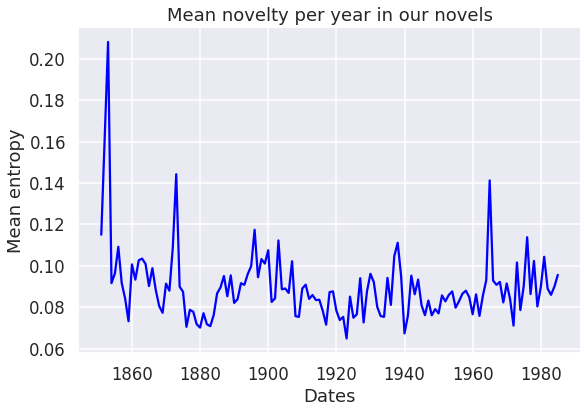

In [42]:
plt.figure(figsize=(9,6))
ax = plt.subplot()
ax.set_title('Mean novelty per year in our novels')

ax = sns.lineplot(data=df_novelty, 
                 x='Date', 
                 y='Mean Entropy', 
                 color='blue', 
                 ax=ax)

ax.set_xlabel('Dates')
ax.set_ylabel('Mean entropy')

plt.show()

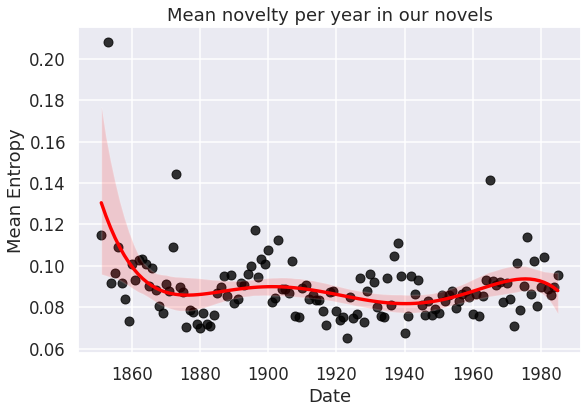

In [48]:
plt.figure(figsize=(9,6))
ax = plt.subplot()
ax.set_title('Mean novelty per year in our novels')

ax = sns.regplot(data=df_novelty, 
                 x='Date', 
                 y='Mean Entropy', 
                 scatter_kws={"color": "black"}, 
                 line_kws={"color": "red"},              
                 order=5, 
                 scatter=True, 
                 ax=ax)

plt.show()

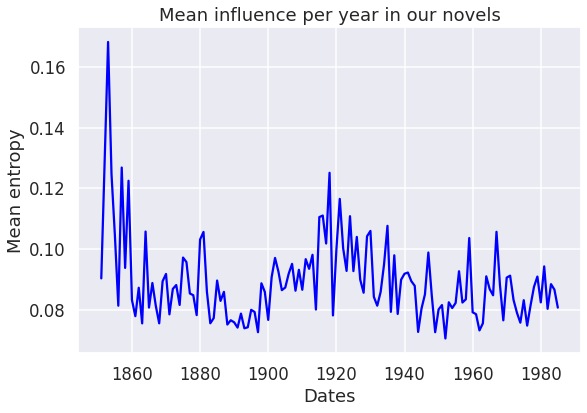

In [49]:
plt.figure(figsize=(9,6))
ax = plt.subplot()
ax.set_title('Mean influence per year in our novels')

ax = sns.lineplot(data=df_influence, 
                 x='Date', 
                 y='Mean Entropy', 
                 color='blue', 
                 ax=ax)

ax.set_xlabel('Dates')
ax.set_ylabel('Mean entropy')

plt.show()

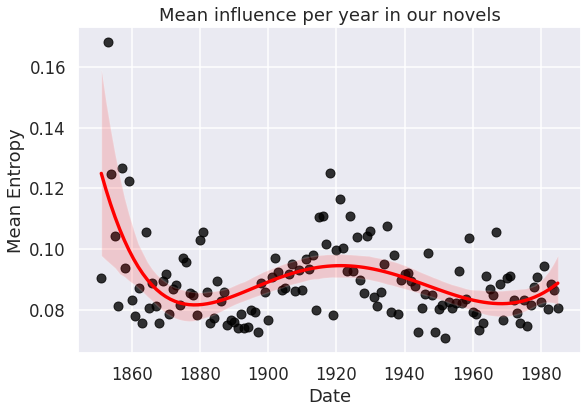

In [50]:
plt.figure(figsize=(9,6))
ax = plt.subplot()
ax.set_title('Mean influence per year in our novels')

ax = sns.regplot(data=df_influence, 
                 x='Date', 
                 y='Mean Entropy', 
                 scatter_kws={"color": "black"}, 
                 line_kws={"color": "red"},              
                 order=5, 
                 scatter=True, 
                 ax=ax)

plt.show()